In [3]:
import os
import pandas as pd
from PIL import Image
from collections import Counter

In [25]:
odkud = "downloads/obalky-martinus"

In [17]:
def process_image(filename):
    # Open the image file
    with Image.open(filename) as img:

        if img.size != (315, 434):
            # Resize the image to 315x434 pixels
            img = img.resize((315, 434), Image.Resampling.LANCZOS)
        
        # Convert the image to 256 colors
        img = img.convert('P', palette=Image.ADAPTIVE, colors=256)

        # Get the color palette
        palette = img.getpalette()

        # Flatten the image into a list of pixels
        pixels = list(img.getdata())

        # Count the number of pixels for each color
        color_counts = Counter(pixels)

        # Convert the color indices to hexadecimal RGB codes
        color_counts_hex = {f'#{palette[i*3]:02x}{palette[i*3+1]:02x}{palette[i*3+2]:02x}': count for i, count in color_counts.items()}

        return color_counts_hex

In [41]:
fosilie = process_image(os.path.join(odkud,'9788076374003.jpg'))
fosilie

{'#9798a1': 815,
 '#a5a9a2': 356,
 '#84858c': 806,
 '#8e8f94': 783,
 '#8f939d': 746,
 '#85898f': 626,
 '#858e98': 511,
 '#8c8c96': 682,
 '#8e909c': 711,
 '#98a0ab': 642,
 '#808190': 811,
 '#8b8895': 485,
 '#808087': 586,
 '#807a87': 576,
 '#848593': 645,
 '#7a798a': 1056,
 '#7a7881': 548,
 '#858996': 659,
 '#8f97a1': 514,
 '#777281': 667,
 '#7b8798': 286,
 '#616272': 621,
 '#716e7d': 960,
 '#757b7e': 117,
 '#9a9f9d': 342,
 '#a9c0b8': 628,
 '#a5b4ab': 402,
 '#bac1ba': 417,
 '#adb3a9': 661,
 '#989991': 300,
 '#8d8889': 360,
 '#aec3bb': 520,
 '#72737d': 294,
 '#3e3c4f': 354,
 '#646e70': 71,
 '#a5ada2': 649,
 '#9ba79d': 428,
 '#4b546b': 503,
 '#526074': 382,
 '#647295': 377,
 '#7b7f8f': 720,
 '#96afab': 225,
 '#a5beb4': 497,
 '#8194a0': 232,
 '#4c4a57': 261,
 '#6a686d': 300,
 '#97918d': 161,
 '#858284': 287,
 '#687786': 402,
 '#99b3bf': 584,
 '#6c6e6d': 81,
 '#a29e95': 301,
 '#857c7c': 260,
 '#7d7274': 341,
 '#837270': 82,
 '#8a7b75': 282,
 '#978b83': 317,
 '#716863': 131,
 '#7f6864': 296,

In [59]:
pd.Series(fosilie).sort_values()

#646e70      71
#6c6e6d      81
#837270      82
#68625f      87
#f5f8f7     100
           ... 
#7a798a    1056
#696759    1259
#f8f6f7    1329
#f6f8f7    1974
#f7f7f7    2794
Length: 256, dtype: int64

In [61]:
pd.Series(fosilie).sum()

136710

In [89]:
# Function to convert a color string to an RGB tuple
def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))

total_width = pd.Series(fosilie).max()
total_height = len(fosilie)

# Create a new image with the calculated dimensions
img = Image.new('RGB', (total_width, total_height))

# Draw each color as a separate row
y = 0
for color, width in fosilie.items():
  rgb_color = hex_to_rgb(color)
  for x in range(width):
    img.putpixel((x, y), rgb_color)
  # Increment y for the next row
  y += 1

# Save the image
img.save(os.path.join('data_raw','image.png'))

In [91]:
import math
def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with specified dimensions.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    # Calculate scaling factors
    input_width = pd.Series(fosilie).max()
    input_height = len(fosilie)
    
    width_scale = output_width / input_width
    height_scale = output_height / input_height
    
    # Draw each color as a scaled row
    for row_idx, (color, width) in enumerate(fosilie.items()):
        rgb_color = hex_to_rgb(color)
        
        # Calculate the vertical position and height for this row
        y_start = math.floor(row_idx * height_scale)
        y_end = math.floor((row_idx + 1) * height_scale)
        
        # Fill the entire row width
        for y in range(y_start, y_end):
            for x in range(output_width):
                # Calculate what portion of the original width this pixel corresponds to
                original_x = math.floor(x / width_scale)
                # Only color pixels that fall within the original width
                if original_x < width:
                    img.putpixel((x, y), rgb_color)
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

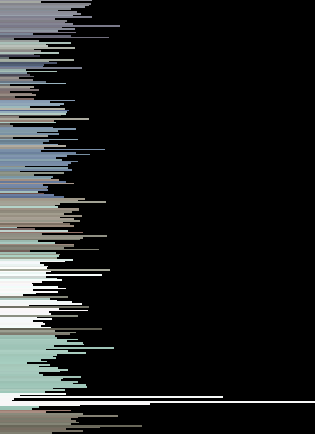

In [93]:
create_color_image(fosilie)

In [95]:
def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with specified dimensions, wrapping colors to fill the entire canvas.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    current_x = 0
    current_y = 0
    
    # Iterate through each color and its width
    for color, width in fosilie.items():
        rgb_color = hex_to_rgb(color)
        
        # Place each pixel of this color
        for _ in range(width):
            img.putpixel((current_x, current_y), rgb_color)
            
            current_x += 1
            # If we reach the end of a line, move to the next line
            if current_x >= output_width:
                current_x = 0
                current_y += 1
                # If we reach the bottom, start back at the top
                if current_y >= output_height:
                    current_y = 0
    
    # Fill any remaining pixels if we haven't filled the entire image
    while current_y < output_height:
        while current_x < output_width:
            img.putpixel((current_x, current_y), rgb_color)  # Use the last color to fill
            current_x += 1
        current_x = 0
        current_y += 1
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

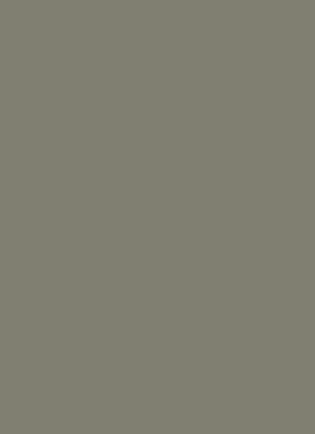

In [97]:
create_color_image(fosilie)

In [99]:
from itertools import cycle

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with specified dimensions, cycling through colors to fill the canvas.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    # Create color-width pairs for cycling
    color_width_pairs = [(color, width) for color, width in fosilie.items()]
    color_cycle = cycle(color_width_pairs)
    
    current_x = 0
    current_y = 0
    current_color, remaining_width = next(color_cycle)
    
    # Fill the entire canvas
    for y in range(output_height):
        for x in range(output_width):
            # If we've used up the current color's width, get the next color
            if remaining_width <= 0:
                current_color, remaining_width = next(color_cycle)
            
            # Place the pixel
            rgb_color = hex_to_rgb(current_color)
            img.putpixel((x, y), rgb_color)
            remaining_width -= 1
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img



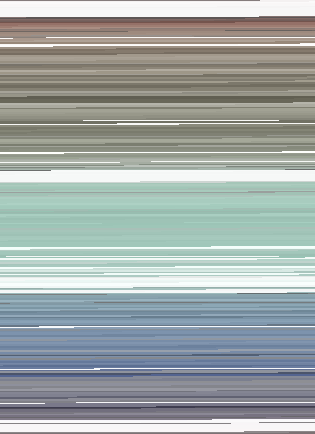

In [105]:
create_color_image(fosilie)

In [87]:
from collections import OrderedDict

# Function to convert a color string to an RGB tuple
def hex_to_rgb(hex_color):
  return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))

# Define target resolution
target_width = 315
target_height = 434

# Sort colors by their average RGB value
def sort_by_average_rgb(color_dict):
  # Convert hex to RGB tuples
  rgb_dict = {color: hex_to_rgb(color) for color in color_dict}
  # Calculate average RGB for each color
  average_rgb = {color: sum(rgb) / 3 for color, rgb in rgb_dict.items()}
  # Sort dictionary by average RGB in ascending order
  return OrderedDict(sorted(average_rgb.items(), key=lambda x: x[1]))

# Sort the fosilie dictionary by average RGB
fosilie_sorted = sort_by_average_rgb(fosilie.copy())

# Create a new image with the target dimensions
img = Image.new('RGB', (target_width, target_height))

# Draw each color in sorted order, adjusting for target height
y = 0
row_height = int(target_height / len(fosilie_sorted))  # Approximate row height
for color, width in fosilie_sorted.items():
  rgb_color = hex_to_rgb(color)
  for x in range(int(width)):  # Convert width to integer
    img.putpixel((x, y), rgb_color)
  # Adjust y for next row, considering extra pixels 
  remaining_pixels = target_height - (len(fosilie_sorted) * row_height)
  y += row_height + int(remaining_pixels / len(fosilie_sorted))

# Save the image
img.save(os.path.join('data_raw','image.png'))


In [103]:
from PIL import Image
import pandas as pd
import os
from itertools import cycle
import colorsys

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with specified dimensions, cycling through spectrally-sorted colors.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    def hex_to_hsv(hex_color):
        """Convert hex color to HSV values"""
        rgb = hex_to_rgb(hex_color)
        return colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    
    # Sort colors by hue
    sorted_colors = sorted(
        fosilie.items(),
        key=lambda x: hex_to_hsv(x[0])[0]  # Sort by hue value
    )
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    # Create color-width pairs for cycling
    color_cycle = cycle(sorted_colors)
    
    current_x = 0
    current_y = 0
    current_color, remaining_width = next(color_cycle)
    
    # Fill the entire canvas
    for y in range(output_height):
        for x in range(output_width):
            # If we've used up the current color's width, get the next color
            if remaining_width <= 0:
                current_color, remaining_width = next(color_cycle)
            
            # Place the pixel
            rgb_color = hex_to_rgb(current_color)
            img.putpixel((x, y), rgb_color)
            remaining_width -= 1
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

# Example usage:
# fosilie = {'#FF0000': 10, '#00FF00': 15, '#0000FF': 20}
# create_color_image(fosilie)

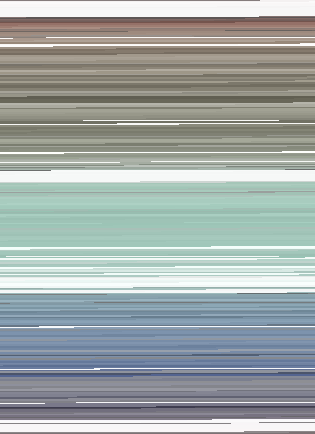

In [107]:
create_color_image(fosilie)

In [117]:
from PIL import Image
import pandas as pd
import os
from itertools import cycle
import colorsys
import numpy as np

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with smooth spectral color transitions.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    def hex_to_hsv(hex_color):
        """Convert hex color to HSV values"""
        rgb = hex_to_rgb(hex_color)
        return colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    
    def interpolate_colors(color1, color2, steps):
        """Interpolate between two RGB colors"""
        rgb1 = np.array(hex_to_rgb(color1))
        rgb2 = np.array(hex_to_rgb(color2))
        return [tuple(map(int, rgb)) for rgb in np.linspace(rgb1, rgb2, steps)]
    
    # Sort colors by hue
    sorted_colors = sorted(
        fosilie.items(),
        key=lambda x: hex_to_hsv(x[0])[0]
    )
    
    # Create the image array
    img = Image.new('RGB', (output_width, output_height))
    pixels = img.load()
    
    # Calculate total width of all colors
    total_width = sum(width for _, width in sorted_colors)
    
    # Calculate how many times we need to repeat the pattern
    total_pixels = output_width * output_height
    repetitions = (total_pixels // total_width) + 1
    
    # Create extended color list with interpolation
    extended_colors = []
    for i in range(len(sorted_colors)):
        current_color, current_width = sorted_colors[i]
        next_color, _ = sorted_colors[(i + 1) % len(sorted_colors)]
        
        # Create base colors for the current segment
        base_colors = [hex_to_rgb(current_color)] * (current_width - 1)
        
        # Add interpolated transition to next color
        transition_colors = interpolate_colors(current_color, next_color, 10)
        extended_colors.extend(base_colors + transition_colors)
    
    # Create cycled color pattern
    color_cycle = cycle(extended_colors)
    
    # Fill the image with smooth transitions
    for y in range(output_height):
        y_offset = int(y * 1.5)  # Add slight vertical offset for variety
        for x in range(output_width):
            # Add slight horizontal variation to avoid straight lines
            x_offset = int(np.sin(y * 0.1) * 3)
            index = (y_offset + x + x_offset) % len(extended_colors)
            pixels[x, y] = extended_colors[index]
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

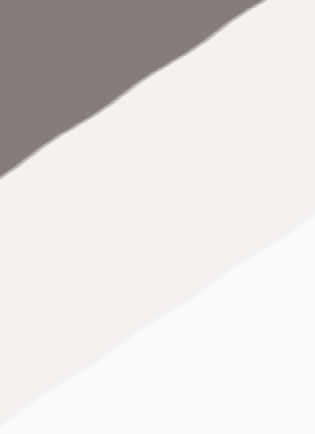

In [119]:
create_color_image(fosilie)

In [113]:
from PIL import Image
import pandas as pd
import os
from itertools import cycle
import colorsys
import numpy as np

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with preserved colors and smooth transitions.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    def hex_to_hsv(hex_color):
        """Convert hex color to HSV values"""
        rgb = hex_to_rgb(hex_color)
        return colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    
    def interpolate_colors(color1, color2, steps):
        """Interpolate between two RGB colors"""
        rgb1 = np.array(hex_to_rgb(color1))
        rgb2 = np.array(hex_to_rgb(color2))
        return [tuple(map(int, rgb)) for rgb in np.linspace(rgb1, rgb2, steps)]
    
    # Sort colors by hue
    sorted_colors = sorted(
        fosilie.items(),
        key=lambda x: hex_to_hsv(x[0])[0]
    )
    
    # Create the image
    img = Image.new('RGB', (output_width, output_height))
    pixels = img.load()
    
    # Create extended color list with brief transitions
    extended_colors = []
    transition_length = 5  # Shorter transition
    
    for i in range(len(sorted_colors)):
        current_color, current_width = sorted_colors[i]
        next_color, _ = sorted_colors[(i + 1) % len(sorted_colors)]
        
        # Add main color section
        main_colors = [hex_to_rgb(current_color)] * (current_width - transition_length)
        transition_colors = interpolate_colors(current_color, next_color, transition_length)
        
        extended_colors.extend(main_colors)
        extended_colors.extend(transition_colors)
    
    # Calculate total pattern length
    pattern_length = len(extended_colors)
    
    # Fill the image
    for y in range(output_height):
        offset = int(y * 0.2)  # Reduced vertical offset
        for x in range(output_width):
            index = (x + offset) % pattern_length
            pixels[x, y] = extended_colors[index]
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

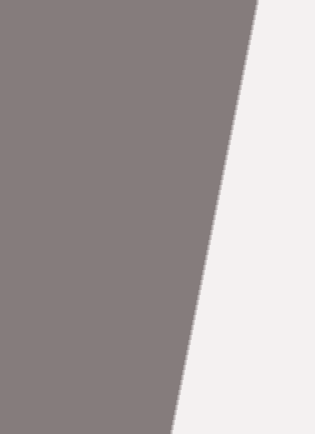

In [115]:
create_color_image(fosilie)

In [121]:
from PIL import Image
import pandas as pd
import os
from itertools import cycle
import colorsys

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with specified dimensions, cycling through intelligently sorted colors.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    def hex_to_hsv(hex_color):
        """Convert hex color to HSV values"""
        rgb = hex_to_rgb(hex_color)
        return colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    
    def color_distance(color1, color2):
        """Calculate perceptual distance between two colors in HSV space"""
        hsv1 = hex_to_hsv(color1)
        hsv2 = hex_to_hsv(color2)
        
        # Handle hue wrap-around
        h1, h2 = hsv1[0], hsv2[0]
        h_diff = min(abs(h1 - h2), 1 - abs(h1 - h2))
        
        # Weight the components
        h_weight = 1.0
        s_weight = 0.3
        v_weight = 0.7
        
        return (h_weight * h_diff +
                s_weight * abs(hsv1[1] - hsv2[1]) +
                v_weight * abs(hsv1[2] - hsv2[2]))

    def sort_colors(colors):
        """Sort colors using nearest neighbor approach"""
        if not colors:
            return []
        
        # Start with the color that has the highest value (brightness)
        available = list(colors)
        start = max(available, key=lambda x: hex_to_hsv(x[0])[2])
        sorted_colors = [start]
        available.remove(start)
        
        while available:
            current = sorted_colors[-1]
            # Find the closest color to the current one
            next_color = min(available, 
                           key=lambda x: color_distance(current[0], x[0]))
            sorted_colors.append(next_color)
            available.remove(next_color)
        
        return sorted_colors
    
    # Sort colors using our new sorting method
    sorted_colors = sort_colors(fosilie.items())
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    # Create color-width pairs for cycling
    color_cycle = cycle(sorted_colors)
    
    current_x = 0
    current_y = 0
    current_color, remaining_width = next(color_cycle)
    
    # Fill the entire canvas
    for y in range(output_height):
        for x in range(output_width):
            # If we've used up the current color's width, get the next color
            if remaining_width <= 0:
                current_color, remaining_width = next(color_cycle)
            
            # Place the pixel
            rgb_color = hex_to_rgb(current_color)
            img.putpixel((x, y), rgb_color)
            remaining_width -= 1
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

# Example usage:
# fosilie = {'#FF0000': 10, '#00FF00': 15, '#0000FF': 20}
# create_color_image(fosilie)

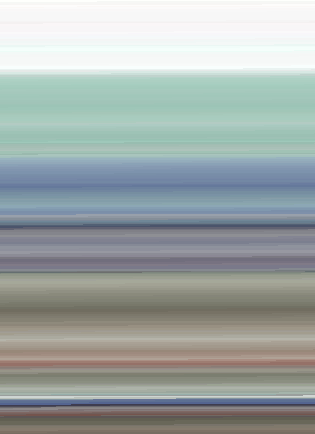

In [123]:
create_color_image(fosilie)

In [125]:
from PIL import Image
import pandas as pd
import os
from itertools import cycle
import colorsys

def create_color_image(fosilie, output_width=315, output_height=434):
    """
    Convert color data to an image with colors arranged from dark to light to dark vertically.
    
    Args:
        fosilie (dict): Dictionary of hex colors and their widths
        output_width (int): Desired output width in pixels
        output_height (int): Desired output height in pixels
    """
    def hex_to_rgb(hex_color):
        """Convert hex color string to RGB tuple"""
        return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
    
    def hex_to_hsv(hex_color):
        """Convert hex color to HSV values"""
        rgb = hex_to_rgb(hex_color)
        return colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    
    def get_brightness(color):
        """Get the brightness (value) of a color"""
        return hex_to_hsv(color)[2]
    
    def sort_colors_symmetric(colors):
        """Sort colors for symmetric dark-light-dark pattern"""
        # Convert items to list and sort by brightness
        color_items = list(colors.items())
        sorted_by_brightness = sorted(color_items, key=lambda x: get_brightness(x[0]))
        
        # Calculate middle point for output height
        total_pixels = output_width * output_height
        
        # Split colors into dark and light groups
        n_colors = len(sorted_by_brightness)
        dark_colors = sorted_by_brightness[:n_colors//2]
        light_colors = sorted_by_brightness[n_colors//2:]
        
        # Sort light colors by hue for better transitions
        light_colors.sort(key=lambda x: hex_to_hsv(x[0])[0])
        
        # Create the sequence: dark -> light -> dark (different dark colors)
        # Reverse the dark colors to start with the darkest
        first_half = list(reversed(dark_colors[:len(dark_colors)//2]))
        middle = light_colors
        second_half = dark_colors[len(dark_colors)//2:]
        
        # Combine all parts
        return first_half + middle + second_half
    
    # Sort colors using our new symmetric sorting method
    sorted_colors = sort_colors_symmetric(fosilie)
    
    # Create a new image with the specified dimensions
    img = Image.new('RGB', (output_width, output_height))
    
    # Create color-width pairs for cycling
    color_cycle = cycle(sorted_colors)
    
    current_x = 0
    current_y = 0
    current_color, remaining_width = next(color_cycle)
    
    # Fill the entire canvas
    for y in range(output_height):
        for x in range(output_width):
            # If we've used up the current color's width, get the next color
            if remaining_width <= 0:
                current_color, remaining_width = next(color_cycle)
            
            # Place the pixel
            rgb_color = hex_to_rgb(current_color)
            img.putpixel((x, y), rgb_color)
            remaining_width -= 1
    
    # Save the image
    img.save(os.path.join('data_raw', 'image.png'))
    return img

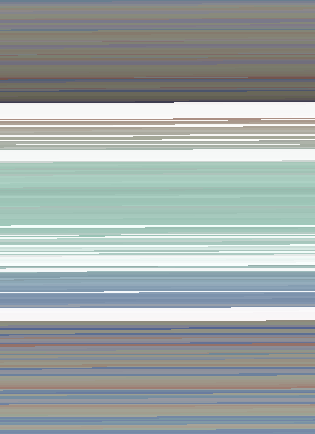

In [127]:
create_color_image(fosilie)

In [29]:
barvy = []
for i in os.listdir(odkud)[0:5]:
    barvy.append(process_image(os.path.join(odkud,i)))

In [35]:
pd.DataFrame(barvy).sum().nlargest()

#646324    81349.0
#283a8e    55549.0
#13100b    46997.0
#ffffff    26560.0
#883501    24247.0
dtype: float64

In [ ]:

# List of your image files
image_files = ['image1.jpg', 'image2.jpg', 'image3.jpg']

# Process each image
for image_file in image_files:
    color_counts = process_image(image_file)
    print(f"Color counts for {image_file}:")
    print(color_counts)

In [ ]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)